In [1]:
# !apt-get update
# !apt-get upgrade
# !apt-get install python-software-properties

!apt-get install net-tools
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


#__connect-googledrive__
!mkdir -p Drive
!google-drive-ocamlfuse Drive

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  net-tools
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 194 kB of archives.
After this operation, 803 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 net-tools amd64 1.60+git20161116.90da8a0-1ubuntu1 [194 kB]
Fetched 194 kB in 4s (53.6 kB/s)
Selecting previously unselected package net-tools.
(Reading database ... 132684 files and directories currently installed.)
Preparing to unpack .../net-tools_1.60+git20161116.90da8a0-1ubuntu1_amd64.deb ...
Unpacking net-tools (1.60+git20161116.90da8a0-1ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up net-tools (1.60+git20161116.90da8a0-1ubuntu1) ...
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database 

In [0]:
#__upload_file__
#solve_error[https://github.com/googlecolab/colabtools/issues/17]
# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving olist_customers_dataset.csv to olist_customers_dataset.csv
User uploaded file "olist_customers_dataset.csv" with length 9033957 bytes


In [0]:
%%bash
cd Drive/WiDS/
ls

commerce_corr_Result.csv
commerce_corr_Result.desktop
E-commerce


In [0]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from functools import reduce
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [0]:
#__read_data__
#row_count : 99441
order_dataset = pd.read_csv("Drive/WiDS/E-commerce/olist_orders_dataset.csv")
#row_count : 99441
customer_dataset = pd.read_csv("Drive/WiDS/E-commerce/olist_customers_dataset.csv")
#row_count : 103886
order_payment_dataset = pd.read_csv("Drive/WiDS/E-commerce/olist_order_payments_dataset.csv")
#row_count : 112650
order_item_dataset = pd.read_csv("Drive/WiDS/E-commerce/olist_order_items_dataset.csv")
#row_count : 100000
order_reviews_dataset = pd.read_csv("Drive/WiDS/E-commerce/olist_order_reviews_dataset.csv")
#row_count : 32951
products_dataset = pd.read_csv("Drive/WiDS/E-commerce/olist_products_dataset.csv")
products_name_translation = pd.read_csv("Drive/WiDS/E-commerce/product_category_name_translation.csv")


In [4]:
#__payment__(因credit_card, boleto佔了9成，故將剩餘付款方式將取代為others)
#__column__(order_id, 訂單中使用boleto付款商品數, 訂單中使用cc付款商品數, 訂單中使用others付款商品數, 使用信用卡分期期數,訂單中使用boleto付款金額, 訂單中使用cc付款金額, 訂單中使用others付款金額 )

# order_payment_dataset['payment_type'].unique().tolist()

order_payment_dataset['payment_cnt'] = 1
vals_to_replace = {'credit_card':'credit_card', 'boleto':'boleto', 'voucher':'others', 'debit_card':'others', 'not_defined':'others'}
order_payment_dataset['payment_type_new'] = order_payment_dataset['payment_type'].map(vals_to_replace)
order_payment_update = order_payment_dataset[['order_id', 'payment_type_new', 'payment_installments', 'payment_value', 'payment_cnt']]
order_payment_update = order_payment_update.groupby(['order_id','payment_type_new'],as_index=False).agg({'payment_installments': 'sum','payment_value': 'sum', 'payment_cnt': 'sum'})
payment_pivot = order_payment_update.pivot_table(order_payment_update, index=['order_id'],columns='payment_type_new')
order_payment_Result = pd.DataFrame(payment_pivot.to_records())
order_payment_Result = order_payment_Result.iloc[:, [0,1,2,3,5,7,8,9]]
order_payment_Result.columns = ['order_id','payment_cnt_boleto', 'payment_cnt_creditcard', 'payment_cnt_others', 'credit_card_installments', 'payment_value_boleto', 'payment_value_creditcard', 'payment_value_others']
order_payment_Result['total_value'] = order_payment_Result.payment_value_boleto.fillna(0) + order_payment_Result.payment_value_creditcard.fillna(0) + order_payment_Result.payment_value_others.fillna(0)
order_payment_Result


# payment_Result.loc[payment_Result['order_id'] == 'ccf804e764ed5650cd8759557269dc13']

,order_id,payment_cnt_boleto,payment_cnt_creditcard,payment_cnt_others,credit_card_installments,payment_value_boleto,payment_value_creditcard,payment_value_others,total_value
0,00010242fe8c5a6d1ba2dd792cb16214,NaN,1.0,NaN,2.0,NaN,72.19,NaN,72.19
1,00018f77f2f0320c557190d7a144bdd3,NaN,1.0,NaN,3.0,NaN,259.83,NaN,259.83
2,000229ec398224ef6ca0657da4fc703e,NaN,1.0,NaN,5.0,NaN,216.87,NaN,216.87
3,00024acbcdf0a6daa1e931b038114c75,NaN,1.0,NaN,2.0,NaN,25.78,NaN,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,NaN,1.0,NaN,3.0,NaN,218.04,NaN,218.04
...,...,...,...,...,...,...,...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,1.0,NaN,NaN,NaN,343.40,NaN,NaN,343.40
99436,fffcd46ef2263f404302a634eb57f7eb,1.0,NaN,NaN,NaN,386.53,NaN,NaN,386.53
99437,fffce4705a9662cd70adb13d4a31832d,NaN,1.0,NaN,3.0,NaN,116.85,NaN,116.85
99438,fffe18544ffabc95dfada21779c9644f,NaN,1.0,NaN,3.0,NaN,64.71,NaN,64.71


In [9]:
#__item__(紀錄訂單中各個商品 join出商品名稱 merge)
order_item_product = pd.merge(order_item_dataset[['order_item_id','order_id', 'product_id', 'price', 'freight_value']], products_dataset, on='product_id', how='left') 
order_itme_product_trans = pd.merge(order_item_product, products_name_translation, on='product_category_name', how='left') 
order_itme_product_trans["product_main_category"].fillna("未定義", inplace = True) 
order_itme_product_trans['cat_cnt']=1
aggregations = {
    'order_item_id': {
        'order_item_cnt': 'max' 
    },
    'price': {
        'order_total_price': 'sum' 
    },
    'freight_value': {
        'order_freight_value': 'sum'
    },
    'product_main_category': {
        'order_prod_category_distint_cnt': 'nunique' 
    },
    'product_id': {
        'order_prod_id_distint_cnt': 'nunique' 
    }
}

order_itme_product_trans_update = order_itme_product_trans.groupby(['order_id']).agg(aggregations).reset_index()
order_itme_product_trans_update.columns = order_itme_product_trans_update.columns.droplevel(0)
order_itme_product_trans['total_price'] = order_itme_product_trans['price'] + order_itme_product_trans['freight_value']
category_update = order_itme_product_trans.groupby(['order_id','product_main_category'],as_index=False).agg({'cat_cnt': 'sum','total_price': 'sum'})
category_pivot = category_update.pivot_table(category_update, index=['order_id'],columns='product_main_category')
category_pivot_update = pd.DataFrame(category_pivot.to_records())
order_itme_product_trans_update.rename(columns={ order_itme_product_trans_update.columns[0]: "order_id" }, inplace = True)
order_item_result = pd.merge(order_itme_product_trans_update, category_pivot_update, on='order_id')
order_item_result.columns = ['order_id','order_item_cnt', 'order_total_price', 'order_freight_value', 'order_prod_category_distint_cnt', 'order_prod_id_distint_cnt',  '休閒生活_cnt', '其他_cnt', '家居生活_cnt', '未定義_cnt', '休閒生活_price', '其他_price', '家居生活_price', '未定義_price']
order_item_result.fillna(0, inplace = True) 
# order_item_result['product_category_name_english'] = order_item_result['product_category_name_english'].apply(lambda x: ', '.join(sorted(set(x.split(',')))))
# order_item_result

# order_item_result.loc[order_item_result['order_item_cnt'] > 2]
order_item_result

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,order_id,order_item_cnt,order_total_price,order_freight_value,order_prod_category_distint_cnt,order_prod_id_distint_cnt,休閒生活_cnt,其他_cnt,家居生活_cnt,未定義_cnt,休閒生活_price,其他_price,家居生活_price,未定義_price
0,00010242fe8c5a6d1ba2dd792cb16214,1,58.90,13.29,1,1,0.0,1.0,0.0,0.0,0.00,72.19,0.00,0.0
1,00018f77f2f0320c557190d7a144bdd3,1,239.90,19.93,1,1,1.0,0.0,0.0,0.0,259.83,0.00,0.00,0.0
2,000229ec398224ef6ca0657da4fc703e,1,199.00,17.87,1,1,0.0,0.0,1.0,0.0,0.00,0.00,216.87,0.0
3,00024acbcdf0a6daa1e931b038114c75,1,12.99,12.79,1,1,1.0,0.0,0.0,0.0,25.78,0.00,0.00,0.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,199.90,18.14,1,1,0.0,0.0,1.0,0.0,0.00,0.00,218.04,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1,299.99,43.41,1,1,0.0,0.0,1.0,0.0,0.00,0.00,343.40,0.0
98662,fffcd46ef2263f404302a634eb57f7eb,1,350.00,36.53,1,1,1.0,0.0,0.0,0.0,386.53,0.00,0.00,0.0
98663,fffce4705a9662cd70adb13d4a31832d,1,99.90,16.95,1,1,1.0,0.0,0.0,0.0,116.85,0.00,0.00,0.0
98664,fffe18544ffabc95dfada21779c9644f,1,55.99,8.72,1,1,1.0,0.0,0.0,0.0,64.71,0.00,0.00,0.0


In [6]:
# order_itme_product_trans.loc[order_itme_product_trans['product_category_name_english'].isnull()]
order_item_result.describe()
# order_itme_product_trans_update.loc[(order_itme_product_trans_update['order_item_cnt'] != order_itme_product_trans_update['order_prod_category_cnt'])]

,order_item_cnt,order_total_price,order_freight_value,order_prod_category_distint_cnt,order_prod_id_distint_cnt,休閒生活_cnt,其他_cnt,家居生活_cnt,未定義_cnt,休閒生活_price,其他_price,家居生活_price,未定義_price
count,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.00000,98666.000000,98666.000000,98666.000000,98666.000000
mean,1.141731,137.754076,22.823562,1.003618,1.038098,0.447185,0.048527,0.629528,0.01649,67.013305,9.197032,82.201784,2.165517
std,0.538452,210.645145,21.650909,0.061048,0.226456,0.616249,0.237422,0.725743,0.14422,168.837366,69.812844,168.798937,32.130400
min,1.000000,0.850000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,45.900000,13.850000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,86.900000,17.170000,1.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,36.445000,0.000000
75%,1.000000,149.900000,24.040000,1.000000,1.000000,1.000000,0.000000,1.000000,0.00000,82.327500,0.000000,107.270000,0.000000
max,21.000000,13440.000000,1794.960000,3.000000,8.000000,20.000000,7.000000,21.000000,6.00000,6922.210000,6081.540000,13664.080000,4042.740000


In [7]:
#__review__(同筆訂單會有多筆回覆/有回覆的標注1)
order_reviews_update = order_reviews_dataset[order_reviews_dataset.groupby('order_id').review_answer_timestamp.transform('max') == order_reviews_dataset['review_answer_timestamp']]
order_reviews_group = order_reviews_dataset.groupby('order_id')['review_comment_message'].apply(lambda x: ','.join(x.astype(str))).reset_index()
order_reviews_group.review_comment_message.replace('nan', np.nan, inplace=True)
order_reviews_group[['review_comment_message']] = order_reviews_group[['review_comment_message']].applymap(lambda x: 0 if pd.isnull(x) else 1)
order_reviews_result = pd.merge(order_reviews_update[['order_id', 'review_score', 'review_answer_timestamp']], order_reviews_group, on='order_id',how='left')
order_reviews_result

,order_id,review_score,review_answer_timestamp,review_comment_message
0,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 21:46:59,0
1,a548910a1c6147796b98fdf73dbeba33,5,2018-03-11 03:05:13,0
2,f9e4b658b201a9f2ecdecbb34bed034b,5,2018-02-18 14:36:24,0
3,658677c97b385a9be170737859d3511b,5,2017-04-21 22:02:06,1
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,2018-03-02 10:26:53,1
...,...,...,...,...
99436,22ec9f0669f784db00fa86d035cf8602,5,2017-12-11 20:06:42,0
99437,55d4004744368f5571d1f590031933e4,5,2018-03-23 09:10:43,1
99438,7725825d039fc1f0ceb7635e3f7d9206,4,2018-07-02 12:59:13,0
99439,f8bd3f2000c28c5342fedeb5e50f2e75,1,2017-12-16 01:29:43,1


In [39]:
# __join_table__
order_join_df = [order_dataset, order_item_result, order_payment_Result, order_reviews_result]
order_detail = reduce(lambda left,right: pd.merge(left,right,on='order_id',how='left'), order_join_df)
order_detail = order_detail.loc[order_detail['order_status'] == 'delivered']
replace_cols = ["payment_cnt_boleto","payment_cnt_creditcard","payment_cnt_others","credit_card_installments","payment_value_boleto","payment_value_creditcard","payment_value_others"]
order_detail[replace_cols] = order_detail[replace_cols].replace({np.nan:0})
order_detail['order_purchase_timestamp'] =  pd.to_datetime(order_detail['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
order_detail['order_delivered_customer_date'] =  pd.to_datetime(order_detail['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
order_detail['review_answer_timestamp'] =  pd.to_datetime(order_detail['review_answer_timestamp'], format='%Y-%m-%d %H:%M:%S')
order_detail['receive_waiting_day'] = order_detail['order_delivered_customer_date'].sub(order_detail['order_purchase_timestamp'], axis=0)
order_detail['receive_waiting_day'] = order_detail['receive_waiting_day'] / np.timedelta64(1, 'D')
order_detail['review_waiting_day'] = order_detail['review_answer_timestamp'].sub(order_detail['order_purchase_timestamp'], axis=0)
order_detail['review_waiting_day'] = order_detail['review_waiting_day'] / np.timedelta64(1, 'D')



customer_update = pd.merge(customer_dataset, order_dataset[['order_id','customer_id','order_purchase_timestamp']], on='customer_id',how='left')
customer_update = customer_update[['customer_unique_id', 'customer_city', 'customer_state','order_purchase_timestamp']]
customer_update.drop_duplicates(subset=None, keep='first', inplace=True)
customer_update_result = customer_update[customer_update.groupby('customer_unique_id').order_purchase_timestamp.transform('max') == customer_update['order_purchase_timestamp']]
customer_update = customer_update[['customer_unique_id', 'customer_city', 'customer_state']]

order_customer_join = pd.merge(order_detail, customer_dataset[['customer_id','customer_unique_id']], on='customer_id',how='left')
order_customer_result = pd.merge(order_customer_join, customer_update, on='customer_unique_id',how='left')
order_customer_join

aggregations_2 = {
    'order_total_price': {
        'sum_order_total_price': 'sum',
        'avg_order_total_price': 'mean'
    },
     'order_freight_value': {
        'sum_order_freight_value': 'sum',
        'avg_order_freight_value': 'mean'
     },
    'order_prod_category_distint_cnt': {
        'avg_order_prod_id_distint_cnt': 'mean' 
    },
    'order_prod_id_distint_cnt': {
        'avg_order_prod_id_distint_cnt': 'mean' 
    },
    'order_item_cnt': {
        'sum_order_item_cnt': 'sum' 
    },
    'payment_cnt_boleto': {
        'sum_payment_cnt_boleto': 'sum' 
    },
    'payment_cnt_creditcard': {
        'sum_payment_cnt_creditcard': 'sum' 
    },
    'payment_cnt_others': {
        'sum_payment_cnt_others': 'sum' 
    },
    'credit_card_installments': {
        'avg_credit_card_installments': 'mean' 
    },
    'payment_value_boleto': {
        'sum_payment_value_boleto': 'sum' 
    },
    'payment_value_creditcard': {
        'sum_payment_value_creditcard': 'sum' 
    },
    'payment_value_others': {
        'sum_payment_value_others': 'sum' 
    },
    'total_value': {
        'sum_total_value': 'sum' ,
        'avg_total_value': 'mean' 
    },
    'review_score': {
        'avg_review_score': 'mean' 
    },
    'review_comment_message': {
        'sum_review_comment_message': 'sum' 
    },
    'order_id': {
        'order_cnt': 'nunique' 
    },
    'receive_waiting_day': {
        'avg_receive_waiting_day': 'mean' 
    },
    'review_waiting_day': {
        'avg_review_waiting_day': 'mean' 
    },
    '休閒生活_cnt': {
        '休閒生活_cnt': 'sum' 
    },
    '其他_cnt': {
        '其他_cnt': 'sum' 
    },
    '家居生活_cnt': {
        '家居生活_cnt': 'sum' 
    },
    '未定義_cnt': {
        '未定義_cnt': 'sum' 
    },
    '休閒生活_price': {
        '休閒生活_price': 'sum' 
    },
    '其他_price': {
        '其他_price': 'sum' 
    },
    '家居生活_price': {
        '家居生活_price': 'sum' 
    },
    '未定義_price': {
        '未定義_price': 'sum' 
    },

}




analysis_input_temp = order_customer_join.groupby(['customer_unique_id']).agg(aggregations_2).reset_index()
analysis_input_temp.columns = analysis_input_temp.columns.droplevel(0)
analysis_input_temp.rename(columns={ analysis_input_temp.columns[0]: "customer_unique_id" }, inplace = True)
analysis_input_temp = analysis_input_temp.dropna(how='any') 
analysis_input_temp
# analysis_input_result
# order_join_customer['customer_unique_id'].nunique()
# customer_update_result[customer_update_result.duplicated(['customer_unique_id'])]
# analysis_input_temp.loc[analysis_input_temp['customer_unique_id'] == '66980c3775537536f77b434d74e520f5']

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,customer_unique_id,sum_order_total_price,avg_order_total_price,sum_order_freight_value,avg_order_freight_value,avg_order_prod_id_distint_cnt,avg_order_prod_id_distint_cnt,sum_order_item_cnt,sum_payment_cnt_boleto,sum_payment_cnt_creditcard,sum_payment_cnt_others,avg_credit_card_installments,sum_payment_value_boleto,sum_payment_value_creditcard,sum_payment_value_others,sum_total_value,avg_total_value,avg_review_score,sum_review_comment_message,order_cnt,avg_receive_waiting_day,avg_review_waiting_day,休閒生活_cnt,其他_cnt,家居生活_cnt,未定義_cnt,休閒生活_price,其他_price,家居生活_price,未定義_price
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,129.90,12.00,12.00,1.0,1.0,1.0,0.0,1.0,0.0,8.0,0.0,141.90,0.0,141.90,141.90,5.0,1,1,6.411227,11.116910,0.0,0.0,1.0,0.0,0.00,0.0,141.90,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,18.90,8.29,8.29,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,27.19,0.0,27.19,27.19,4.0,0,1,3.285590,4.470810,0.0,0.0,1.0,0.0,0.00,0.0,27.19,0.0
2,0000f46a3911fa3c0805444483337064,69.00,69.00,17.22,17.22,1.0,1.0,1.0,0.0,1.0,0.0,8.0,0.0,86.22,0.0,86.22,86.22,3.0,0,1,25.731759,27.176863,0.0,0.0,1.0,0.0,0.00,0.0,86.22,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,25.99,17.63,17.63,1.0,1.0,1.0,0.0,1.0,0.0,4.0,0.0,43.62,0.0,43.62,43.62,4.0,1,1,20.037083,21.158449,0.0,0.0,1.0,0.0,0.00,0.0,43.62,0.0
4,0004aac84e0df4da2b147fca70cf8255,180.00,180.00,16.89,16.89,1.0,1.0,1.0,0.0,1.0,0.0,6.0,0.0,196.89,0.0,196.89,196.89,5.0,0,1,13.141134,18.113808,0.0,0.0,1.0,0.0,0.00,0.0,196.89,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00,1570.00,497.42,497.42,1.0,2.0,2.0,0.0,1.0,0.0,10.0,0.0,2067.42,0.0,2067.42,2067.42,5.0,0,1,27.514861,32.596863,0.0,0.0,2.0,0.0,0.00,0.0,2067.42,0.0
93354,fffea47cd6d3cc0a88bd621562a9d061,64.89,64.89,19.69,19.69,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,84.58,0.0,84.58,84.58,4.0,0,1,30.097500,35.655590,0.0,0.0,1.0,0.0,0.00,0.0,84.58,0.0
93355,ffff371b4d645b6ecea244b27531430a,89.90,89.90,22.56,22.56,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,112.46,0.0,112.46,112.46,5.0,0,1,14.872083,17.968113,1.0,0.0,0.0,0.0,112.46,0.0,0.00,0.0
93356,ffff5962728ec6157033ef9805bacc48,115.00,115.00,18.69,18.69,1.0,1.0,1.0,0.0,1.0,0.0,5.0,0.0,133.69,0.0,133.69,133.69,5.0,1,1,11.858854,14.999063,1.0,0.0,0.0,0.0,133.69,0.0,0.00,0.0


In [0]:
# analysis_input_temp_desc = analysis_input_temp.describe()
# list(analysis_input_temp.columns.values)
analysis_input_temp.to_csv('Drive/WiDS/analysis_input_temp.csv')
# nan_rows = analysis_input_temp[analysis_input_temp.isnull().any(1)]
# nan_rows
# order_detail
# test = pd.merge(order_detail, customer_dataset[['customer_id','customer_unique_id']], on='customer_id')
# test.groupby('customer_unique_id').nunique()
# analysis_input_temp.groupby('order_cnt').count()
# order_customer_join.loc[order_customer_join['customer_unique_id'] == '66980c3775537536f77b434d74e520f5']
# analysis_input_temp.loc[analysis_input_temp['order_cnt'] > 1]

In [33]:
#___basket_analysis___

order_basket = pd.merge(order_itme_product_trans[['order_id', 'product_category_name_english']], order_dataset[['order_id', 'customer_id']], on='order_id', how='left') 
customer_basket = pd.merge(order_basket, customer_dataset[['customer_id', 'customer_unique_id']], on='customer_id', how='left') 
customer_basket_update = customer_basket.sort_values('customer_unique_id').drop_duplicates(subset=['order_id', 'customer_unique_id', 'product_category_name_english'], keep='last')
customer_basket_input = customer_basket_update[customer_basket_update.groupby('customer_unique_id').customer_unique_id.transform(len) > 1]
customer_basket_input[['customer_unique_id', 'product_category_name_english']].sort_values('customer_unique_id')


,customer_unique_id,product_category_name_english
59361,000fbf0473c10fc1ab6f8d2d286ce20c,musical_instruments
59362,000fbf0473c10fc1ab6f8d2d286ce20c,toys
49200,001926cef41060fae572e2e7b30bd2a4,electronics
49201,001926cef41060fae572e2e7b30bd2a4,computers_accessories
74677,001928b561575b2821c92254a2327d06,furniture_living_room
...,...,...
41910,ff922bdd6bafcdf99cb90d7f39cea5b3,bed_bath_table
111431,ff922bdd6bafcdf99cb90d7f39cea5b3,fashion_bags_accessories
47452,ff922bdd6bafcdf99cb90d7f39cea5b3,housewares
103880,ffe254cc039740e17dd15a5305035928,bed_bath_table


In [70]:

basket = pd.crosstab(customer_basket_input['customer_unique_id'], customer_basket_input['product_category_name_english'])

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1


basket_sets = basket.applymap(encode_units)
basket_sets

frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules
# prod_cnt = customer_basket_input.groupby(['product_category_name_english']).count()
# prod_cnt.to_csv('Drive/WiDS/basket_cnt.csv')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(furniture_decor),(bed_bath_table),0.175980,0.212677,0.043369,0.246445,1.158777,0.005943,1.044812
1,(bed_bath_table),(furniture_decor),0.212677,0.175980,0.043369,0.203922,1.158777,0.005943,1.035099
2,(home_confort),(bed_bath_table),0.020573,0.212677,0.015013,0.729730,3.431161,0.010637,2.913094
3,(bed_bath_table),(home_confort),0.212677,0.020573,0.015013,0.070588,3.431161,0.010637,1.053814
4,(furniture_decor),(garden_tools),0.175980,0.063108,0.012788,0.072670,1.151513,0.001683,1.010311
5,(garden_tools),(furniture_decor),0.063108,0.175980,0.012788,0.202643,1.151513,0.001683,1.033439


In [71]:
analysis_input_data = analysis_input_temp[['customer_unique_id', 'sum_payment_cnt_creditcard', 'avg_credit_card_installments', 'sum_payment_value_creditcard', 'avg_total_value', 'avg_review_score', 'sum_review_comment_message', 'order_cnt', 'avg_receive_waiting_day', '休閒生活_cnt', '家居生活_cnt', '休閒生活_price', '家居生活_price' ]]
filter_analysis_input = analysis_input_data.loc[:, analysis_input_data.columns != 'customer_unique_id']
# low = 0
# high = .99
# quant_df = filter_analysis_input.quantile([low, high])
# print(quant_df)
# filter_analysis_input = filter_analysis_input.apply(lambda x: x[(x>=quant_df.loc[low,x.name]) & (x <= quant_df.loc[high,x.name])], axis=0)
# filter_analysis_input = pd.concat([analysis_input_data.loc[:,'customer_unique_id'], filter_analysis_input], axis=1)
# filter_analysis_input.dropna(inplace=True)

# filter_analysis_input

filter_analysis_input['order_cnt_flag'] = np.where((filter_analysis_input['order_cnt']) >=2 , 1, 0)
filter_analysis_input['review_comment_message_flag'] = np.where((filter_analysis_input['sum_review_comment_message']) >=1 , 1, 0)
filter_analysis_input['payment_cnt_creditcard_flag'] = np.where((filter_analysis_input['sum_payment_cnt_creditcard']) >=1 , 1, 0)
filter_analysis_input['休閒生活_flag'] = np.where((filter_analysis_input['休閒生活_cnt']) >=1 , 1, 0)
filter_analysis_input['家居生活_flag'] = np.where((filter_analysis_input['家居生活_cnt']) >=1 , 1, 0)
kmeans_input = filter_analysis_input[['order_cnt_flag', 'review_comment_message_flag', 'payment_cnt_creditcard_flag', 'avg_credit_card_installments', 'avg_total_value', 'avg_review_score', '休閒生活_flag', '家居生活_flag', '休閒生活_price', '家居生活_price']]
kmeans_input.describe()
# analysis_input_data.describe()
# kmeans_input_desc.to_csv('Drive/kmeans_input_desc_test.csv')

,order_cnt_flag,review_comment_message_flag,payment_cnt_creditcard_flag,avg_credit_card_installments,avg_total_value,avg_review_score,休閒生活_flag,家居生活_flag,休閒生活_price,家居生活_price
count,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000
mean,0.030006,0.416416,0.771513,2.694211,160.315615,4.140110,0.409013,0.541773,68.822586,84.795093
std,0.170604,0.492967,0.419860,2.898493,219.580151,1.292168,0.491654,0.498255,172.617762,174.413543
min,0.000000,0.000000,0.000000,0.000000,9.590000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,62.370000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,2.000000,105.630000,5.000000,0.000000,1.000000,0.000000,37.390000
75%,0.000000,1.000000,1.000000,4.000000,176.650000,5.000000,1.000000,1.000000,84.200000,110.580000
max,1.000000,1.000000,1.000000,24.000000,13664.080000,5.000000,1.000000,1.000000,6922.210000,13664.080000


In [0]:

#Cluster the data
kmeans_input_std = stats.zscore(kmeans_input)
kmeans = KMeans(n_clusters=5, max_iter = 30).fit(kmeans_input_std)
labels = kmeans.labels_

#Glue back to originaal data
kmeans_input['clusters'] = labels






/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# kmeans_input
kmeans_input.groupby(['clusters']).sum()

,order_cnt_flag,review_comment_message_flag,payment_cnt_creditcard_flag,avg_credit_card_installments,avg_total_value,avg_review_score,休閒生活_flag,家居生活_flag,休閒生活_price,家居生活_price
clusters,,,,,,,,,,
0,0,13433,33505,99916.0,3365973.21,140490.0,60,29666,3209.64,2809411.96
1,0,10537,26560,81749.0,3963231.57,113606.0,26983,43,3954002.37,3595.99
2,0,7729,0,0.0,1975801.78,79833.0,7904,10028,772422.73,1020591.23
3,2191,1273,1811,6502.0,262101.01,9250.0,1044,1662,182300.39,310725.42
4,0,3313,6500,39831.0,2422352.75,27665.0,29,6741,4501.31,2236515.25


In [0]:
# kmeans_input
kmeans_input.groupby(['clusters']).mean()

,order_cnt_flag,review_comment_message_flag,payment_cnt_creditcard_flag,avg_credit_card_installments,avg_total_value,avg_review_score,休閒生活_flag,家居生活_flag,休閒生活_price,家居生活_price
clusters,,,,,,,,,,
0,0.0,0.400925,1.000000,2.982122,100.461818,4.193106,0.001791,0.885420,0.095796,83.850529
1,0.0,0.390433,0.984141,3.029087,146.851622,4.209501,0.999815,0.001593,146.509648,0.133244
2,0.0,0.405020,0.000000,0.000000,103.537273,4.183462,0.414191,0.525494,40.477007,53.481697
3,1.0,0.581013,0.826563,2.967595,119.626203,4.221817,0.476495,0.758558,83.204194,141.818996
4,0.0,0.472005,0.926058,5.674740,345.113656,3.941445,0.004132,0.960393,0.641304,318.637306


[2 2 2 ... 2 2 2]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 5 0]
[0 0 0 ... 0 6 0]
[2 2 2 ... 2 0 2]


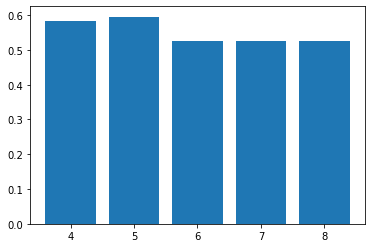

[0.5841913390257649, 0.5955497695041304, 0.5250428396717566, 0.525698996043658, 0.5248401668359404]


In [0]:
X = analysis_input_data[['order_cnt_flag', 'review_comment_message_flag', 'payment_cnt_creditcard_flag', 'avg_credit_card_installments', 'avg_total_value', 'avg_review_score', '休閒生活_flag', '家居生活_flag', '休閒生活_price', '家居生活_price']].values  
X


from sklearn import cluster, datasets, metrics
import matplotlib.pyplot as plt

# 迴圈
silhouette_avgs = []
ks = range(4 , 9)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k).fit(X)
    cluster_labels = kmeans_fit.labels_
    print(cluster_labels)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

# 作圖並印出 k = 2 到 10 的績效
plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)




# from sklearn.cluster import KMeans

# km = KMeans(n_clusters=5)
# new = kmeans_input._get_numeric_data()
# kmeans.fit(new)
# predict=km.predict(new)



          order_cnt_flag  review_comment_message_flag  ...  休閒生活_price  家居生活_price
clusters                                               ...                        
0                  12086                        12086  ...       12086       12086
1                  38820                        38820  ...       38820       38820
2                  37285                        37285  ...       37285       37285
3                   2390                         2390  ...        2390        2390
4                   2768                         2768  ...        2768        2768

[5 rows x 10 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
# print (kmeans_input[clmns].groupby(['clusters']).sum())


kmeans_input.groupby(['clusters']).sum()

,order_cnt_flag,review_comment_message_flag,payment_cnt_creditcard_flag,avg_credit_card_installments,avg_total_value,avg_review_score,休閒生活_flag,家居生活_flag,休閒生活_price,家居生活_price
clusters,,,,,,,,,,
0,0,5035,0,0.000000,1.577896e+06,49784.000000,45,10856,4475.30,1368326.83
1,0,15438,30403,93146.000000,4.982999e+06,162275.000000,34956,43,4423136.36,2914.36
2,0,15552,37285,134105.000000,5.390368e+06,153399.000000,86,37001,7388.19,5195394.37
3,33,1203,2058,15778.000000,2.635026e+06,9421.666667,1735,626,1697092.09,881264.04
4,2768,1644,2274,8472.944444,3.790138e+05,11595.461111,1359,2048,292427.68,467637.54


In [0]:
kmeans_input.groupby(['clusters']).mean()

,order_cnt_flag,review_comment_message_flag,payment_cnt_creditcard_flag,avg_credit_card_installments,avg_total_value,avg_review_score,休閒生活_flag,家居生活_flag,休閒生活_price,家居生活_price
clusters,,,,,,,,,,
0,0.000000,0.416598,0.000000,0.000000,130.555643,4.119146,0.003723,0.898229,0.370288,113.215856
1,0.000000,0.397682,0.783179,2.399433,128.361648,4.180191,0.900464,0.001108,113.939628,0.075074
2,0.000000,0.417111,1.000000,3.596755,144.572020,4.114228,0.002307,0.992383,0.198154,139.342748
3,0.013808,0.503347,0.861088,6.601674,1102.521369,3.942120,0.725941,0.261925,710.080372,368.729724
4,1.000000,0.593931,0.821532,3.061035,136.926957,4.189112,0.490968,0.739884,105.645838,168.944198


In [0]:
import pickle
with open('Drive/WiDS/save_model/kmeans_1.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

In [72]:
with open('Drive/WiDS/save_model/kmeans_1.pickle', 'rb') as f:
    kmeans_1 = pickle.load(f)
    print(kmeans_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


In [73]:
labels = kmeans_1.labels_

#Glue back to originaal data
kmeans_input['clusters'] = labels
kmeans_input

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,order_cnt_flag,review_comment_message_flag,payment_cnt_creditcard_flag,avg_credit_card_installments,avg_total_value,avg_review_score,休閒生活_flag,家居生活_flag,休閒生活_price,家居生活_price,clusters
0,0,1,1,8.0,141.90,5.0,0,1,0.00,141.90,2
1,0,0,1,1.0,27.19,4.0,0,1,0.00,27.19,2
2,0,0,1,8.0,86.22,3.0,0,1,0.00,86.22,2
3,0,1,1,4.0,43.62,4.0,0,1,0.00,43.62,2
4,0,0,1,6.0,196.89,5.0,0,1,0.00,196.89,2
...,...,...,...,...,...,...,...,...,...,...,...
93353,0,0,1,10.0,2067.42,5.0,0,1,0.00,2067.42,3
93354,0,0,1,1.0,84.58,4.0,0,1,0.00,84.58,2
93355,0,0,1,1.0,112.46,5.0,1,0,112.46,0.00,1
93356,0,1,1,5.0,133.69,5.0,1,0,133.69,0.00,1


In [74]:
kmeans_input.groupby(['clusters']).sum()

,order_cnt_flag,review_comment_message_flag,payment_cnt_creditcard_flag,avg_credit_card_installments,avg_total_value,avg_review_score,休閒生活_flag,家居生活_flag,休閒生活_price,家居生活_price
clusters,,,,,,,,,,
0,0,5035,0,0.000000,1.577896e+06,49784.000000,45,10856,4475.30,1368326.83
1,0,15438,30403,93146.000000,4.982999e+06,162275.000000,34956,43,4423136.36,2914.36
2,0,15552,37285,134105.000000,5.390368e+06,153399.000000,86,37001,7388.19,5195394.37
3,33,1203,2058,15778.000000,2.635026e+06,9421.666667,1735,626,1697092.09,881264.04
4,2768,1644,2274,8472.944444,3.790138e+05,11595.461111,1359,2048,292427.68,467637.54


In [75]:
kmeans_input.groupby(['clusters']).mean()

,order_cnt_flag,review_comment_message_flag,payment_cnt_creditcard_flag,avg_credit_card_installments,avg_total_value,avg_review_score,休閒生活_flag,家居生活_flag,休閒生活_price,家居生活_price
clusters,,,,,,,,,,
0,0.000000,0.416598,0.000000,0.000000,130.555643,4.119146,0.003723,0.898229,0.370288,113.215856
1,0.000000,0.397682,0.783179,2.399433,128.361648,4.180191,0.900464,0.001108,113.939628,0.075074
2,0.000000,0.417111,1.000000,3.596755,144.572020,4.114228,0.002307,0.992383,0.198154,139.342748
3,0.013808,0.503347,0.861088,6.601674,1102.521369,3.942120,0.725941,0.261925,710.080372,368.729724
4,1.000000,0.593931,0.821532,3.061035,136.926957,4.189112,0.490968,0.739884,105.645838,168.944198


In [0]:
;df = analysis_input_data.corr(method ='pearson')

In [0]:
# Extract values and row, column names
arr = df.values
index_names = df.index
col_names = df.columns

#  Get indices where such threshold is crossed; avoid diagonal elems
R,C = np.where(np.triu(arr,1)!=1)

# Arrange those in columns and put out as a dataframe
out_arr = np.column_stack((index_names[R],col_names[C],arr[R,C]))
df_out = pd.DataFrame(out_arr,columns=[['row_name','col_name','corr']])

In [0]:
df_out.to_csv("Drive/WiDS/commerce_corr_Result_1113.csv")

In [0]:




test = pd.merge(order_dataset, customer_dataset[['customer_id','customer_unique_id']], on='customer_id')
test['by_cnt']=1
test_result = test['by_cnt'].groupby(test['customer_unique_id']).agg(['count'])
test_result

test_result.loc[test_result['count'] > 1]

,count
customer_unique_id,
00172711b30d52eea8b313a7f2cced02,2
004288347e5e88a27ded2bb23747066c,2
004b45ec5c64187465168251cd1c9c2f,2
0058f300f57d7b93c477a131a59b36c3,2
00a39521eb40f7012db50455bf083460,2
...,...
ff36be26206fffe1eb37afd54c70e18b,3
ff44401d0d8f5b9c54a47374eb48c1b8,2
ff8892f7c26aa0446da53d01b18df463,2
